In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set precision to double for better numerical stability
torch.set_default_dtype(torch.float64)

##############################################################################
# 1. Forward Solver: Viscous Burgers Equation via Explicit Finite Difference
##############################################################################
def simulate_viscous_burgers(u0_func, nu=0.01, x_domain=(0,1), t_domain=(0,1), Nx=101, Nt=200):
    """
    Solve the 1D viscous Burgers' equation:
         u_t + u*u_x = nu*u_xx,
    with Dirichlet boundary conditions using an explicit finite-difference scheme.
    """
    x_arr = np.linspace(x_domain[0], x_domain[1], Nx)
    t0, t1 = t_domain
    dt = (t1-t0) / (Nt-1)
    dx = (x_domain[1]-x_domain[0]) / (Nx-1)
    # CFL conditions: convection and diffusion
    cfl_conv = 0.2 * dx / (1.0 + 1e-6)
    cfl_diff = 0.2 * dx**2 / (nu + 1e-6)
    dt = min(dt, cfl_conv, cfl_diff)
    Nt = int((t1-t0)/dt) + 1
    t_arr = np.linspace(t0, t1, Nt)
    U = np.zeros((Nt, Nx))
    U[0, :] = u0_func(x_arr)
    U[0, 0] = 0.0
    U[0, -1] = 0.0
    for n in range(Nt-1):
        u_n = U[n, :].copy()
        u_n[0] = 0.0
        u_n[-1] = 0.0
        u_next = u_n.copy()
        for i in range(1, Nx-1):
            ux = (u_n[i+1] - u_n[i-1]) / (2*dx)
            uxx = (u_n[i+1] - 2*u_n[i] + u_n[i-1]) / (dx**2)
            # Burgers: u_t = -u*u_x + nu*u_xx
            u_next[i] = u_n[i] + dt * (-u_n[i]*ux + nu*uxx)
        U[n+1, :] = u_next
    return t_arr, x_arr, U

##############################################################################
# 2. Dataset Construction
##############################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def create_burgers_dataset(t_arr, x_arr, U, N_res=1000, N_dat=50):
    """
    Build a dataset with:
      - Residual points (for PDE loss)
      - Data points at final time (for data loss)
      - Initial condition data (for outer-level loss)
    """
    Nt = len(t_arr)
    Nx = len(x_arr)
    T, X = np.meshgrid(t_arr, x_arr, indexing='ij')
    TX = np.column_stack((T.flatten(), X.flatten()))
    idx_res = np.random.choice(TX.shape[0], N_res, replace=False)
    X_res_train = TX[idx_res, :]
    t_final_idx = Nt - 1
    X_dat_full = np.column_stack((t_arr[t_final_idx]*np.ones_like(x_arr), x_arr))
    u_dat_full = U[t_final_idx, :].reshape(-1, 1)
    idx_dat = np.linspace(0, Nx-1, N_dat, dtype=int)
    # For training, we use full collocation for data loss.
    X_dat_train = X_dat_full[idx_dat, :]
    u_dat_train = u_dat_full[idx_dat, :]
    
    dataset = {}
    dataset['X_res_train'] = torch.tensor(X_res_train, dtype=torch.get_default_dtype()).to(device)
    dataset['X_dat_train'] = torch.tensor(X_dat_train, dtype=torch.get_default_dtype()).to(device)
    dataset['u_dat_train'] = torch.tensor(u_dat_train, dtype=torch.get_default_dtype()).to(device)
    dataset['x_ic'] = torch.tensor(x_arr.reshape(-1,1), dtype=torch.get_default_dtype()).to(device)
    dataset['u_ic'] = torch.tensor(U[0, :].reshape(-1,1), dtype=torch.get_default_dtype()).to(device)
    dataset['X_dat'] = torch.tensor(X_dat_full, dtype=torch.get_default_dtype()).to(device)
    dataset['u_dat'] = torch.tensor(u_dat_full, dtype=torch.get_default_dtype()).to(device)
    dataset['t_arr'] = torch.tensor(t_arr, dtype=torch.get_default_dtype()).to(device)
    dataset['x_arr'] = torch.tensor(x_arr, dtype=torch.get_default_dtype()).to(device)
    return dataset

##############################################################################
# 3. Network Definitions
##############################################################################
# 3a. ParamFunction: parameterize the unknown initial condition f(x)
class ParamFunction(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, fdepth=3, fwidth=32,
                 activation='tanh', output_activation='identity'):
        super(ParamFunction, self).__init__()
        layers = []
        act = nn.Tanh() if activation=='tanh' else nn.ReLU()
        layers.append(nn.Linear(input_dim, fwidth))
        layers.append(act)
        for _ in range(fdepth-2):
            layers.append(nn.Linear(fwidth, fwidth))
            layers.append(act)
        layers.append(nn.Linear(fwidth, output_dim))
        self.layers = nn.Sequential(*layers)
        self.out_act = nn.Identity() if output_activation=='identity' else nn.Tanh()
        
        # Initialize weights using Xavier (Glorot) initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        return self.out_act(self.layers(x))

# 3b. BurgerDenseNet: main network that embeds f(x)
class BurgerDenseNet(nn.Module):
    def __init__(self, depth=4, width=64, input_dim=2, output_dim=1,
                 lambda_transform=lambda x, u: u, with_param=True, param_function=None):
        super(BurgerDenseNet, self).__init__()
        self.input_layer = nn.Linear(input_dim, width)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width) for _ in range(depth-2)])
        self.output_layer = nn.Linear(width, output_dim)
        self.activation = nn.Tanh()
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
        self.with_param = with_param
        self.lambda_transform = lambda_transform
        if self.with_param and (param_function is not None):
            self.param_embeddings = nn.Linear(1, width, bias=False)
            for param in self.param_embeddings.parameters():
                param.requires_grad = True
            nn.init.xavier_normal_(self.param_embeddings.weight)
            self.param_function = param_function
            
    def forward(self, x):
        if self.with_param:
            x_coord = x[:, 1:2]
            u0 = self.param_function(x_coord)
            param_embed = self.param_embeddings(u0)
        X = self.input_layer(x)
        if self.with_param:
            X = X + param_embed
        X = self.activation(X)
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        u = self.output_layer(X)
        return self.lambda_transform(x, u)

##############################################################################
# 4. PDE Problem: Viscous Burgers with Unknown Viscosity ν
##############################################################################
class BurgerProblem:
    def __init__(self, dataset, a=1.0, init_nu=0.01):
        """
        a: coefficient in the convection term (set to 1 for consistency with FD scheme)
        init_nu: initial guess for the viscosity parameter
        """
        self.dataset = dataset
        self.a = a
        # Initialize viscosity parameter with double precision
        self.nu = nn.Parameter(torch.tensor(init_nu, dtype=torch.get_default_dtype(), device=device))
        print(f"Initialized nu = {self.nu.item()}, requires_grad = {self.nu.requires_grad}")
        self.param_function = None  # Will be attached later
    
    def residual(self, net, X_in):
        """
        Compute the PDE residual:
           N(u,ν) = u_t + u*u_x - ν*u_xx.
        """
        X_in = X_in.clone().requires_grad_(True)
        u = net(X_in)
        grad_u = torch.autograd.grad(u, X_in,
                                     grad_outputs=torch.ones_like(u),
                                     create_graph=True, retain_graph=True,
                                     allow_unused=True)[0]
        if grad_u is None:
            print("[BurgerProblem.residual] Warning: grad_u is None.")
            grad_u = torch.zeros_like(u)
        u_t = grad_u[:, 0:1]
        u_x = grad_u[:, 1:2]
        grad_ux = torch.autograd.grad(u_x, X_in,
                                      grad_outputs=torch.ones_like(u_x),
                                      create_graph=True, retain_graph=True,
                                      allow_unused=True)[0]
        if grad_ux is None:
            print("[BurgerProblem.residual] Warning: grad_ux is None.")
            grad_ux = torch.zeros_like(u)
        u_xx = grad_ux[:, 1:2]
        r = u_t + self.a * u * u_x - self.nu * u_xx
        return r, u
    
    def residual_loss(self, net):
        X_res = self.dataset['X_res_train']
        r, _ = self.residual(net, X_res)
        return torch.mean(r**2)
    
    def residual_gradient_loss(self, net):
        """
        Compute L2 norm of u_xx as a surrogate for the derivative of the residual.
        """
        X_res = self.dataset['X_res_train']
        X_res.requires_grad_(True)
        _, u = self.residual(net, X_res)
        grad_u = torch.autograd.grad(u, X_res,
                                     grad_outputs=torch.ones_like(u),
                                     create_graph=True, retain_graph=True,
                                     allow_unused=True)[0]
        if grad_u is None:
            grad_u = torch.zeros_like(u)
        u_x = grad_u[:, 1:2]
        grad_ux = torch.autograd.grad(u_x, X_res,
                                      grad_outputs=torch.ones_like(u_x),
                                      create_graph=True, retain_graph=True,
                                      allow_unused=True)[0]
        if grad_ux is None:
            grad_ux = torch.zeros_like(u)
        u_xx = grad_ux[:, 1:2]
        return torch.mean(u_xx**2)
    
    def get_data_loss(self, net):
        X_dat = self.dataset['X_dat_train']
        u_dat = self.dataset['u_dat_train']
        u_pred = net(X_dat)
        return torch.mean((u_pred - u_dat)**2)
    
    def explicit_param_term(self):
        return 0.0
    
    def plot_results(self, net):
        net.eval()
        with torch.no_grad():
            X_test = self.dataset['X_dat']
            u_pred = net(X_test).cpu().numpy()
            x_vals = X_test[:, 1].cpu().numpy()
            plt.figure(figsize=(10, 6))
            plt.plot(x_vals, u_pred, 'r-', linewidth=2, label="Predicted u(x,t=1)")
            plt.scatter(self.dataset['X_dat_train'][:, 1].cpu().numpy(),
                        self.dataset['u_dat_train'].cpu().numpy(), 
                        s=100, label="Data", c='b', alpha=0.6)
            plt.xlabel("x", fontsize=14)
            plt.ylabel("u(x,t=1)", fontsize=14)
            plt.title(f"Viscous Burgers Solution (ν = {self.nu.item():.4f})", fontsize=16)
            plt.legend(fontsize=12)
            plt.grid(True)
            plt.show()
    
    def validate(self, net):
        return self.get_data_loss(net).item()

##############################################################################
# 5. Adjoint Analysis and Hessian Estimation
##############################################################################
def compute_adjoint_variable(prob, net, X_sample, data_points, data_values):
    """
    Compute the adjoint variable λ(x,t) by solving the adjoint equation:
    -λ_t - ∂_x(u·λ) + u_x·λ + ν·λ_xx = -∂J/∂u
    
    For this simplified implementation, we use an approximation based on
    the PDE operator structure and data loss gradient.
    """
    # Compute u and its derivatives at sample points
    X_sample = X_sample.clone().requires_grad_(True)
    u = net(X_sample)
    
    # Get u_x for the adjoint equation
    grad_u = torch.autograd.grad(u, X_sample,
                                grad_outputs=torch.ones_like(u),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
    if grad_u is None:
        print("[compute_adjoint_variable] Warning: grad_u is None.")
        return torch.zeros_like(u)
        
    u_x = grad_u[:, 1:2]
    
    # Initialize source term from data loss gradient
    source_term = torch.zeros_like(u)
    
    # Set values at data points
    with torch.no_grad():
        u_pred_data = net(data_points)
        data_loss_grad = 2 * (u_pred_data - data_values)
        
        # Map data points to nearest sample points
        for i, data_pt in enumerate(data_points):
            # Find closest sample point
            dists = torch.sum((X_sample - data_pt)**2, dim=1)
            idx = torch.argmin(dists)
            source_term[idx] = data_loss_grad[i]
    
    # Compute approximation for adjoint variable
    try:
        # Get residual and derivatives needed for the adjoint
        r, _ = prob.residual(net, X_sample)
        
        # We use the residual to weight the adjoint variable
        # This helps capture the PDE structure better
        
        # We use a linearization for the adjoint: λ ≈ (∂J/∂u)*(∂N/∂u)^{-1}
        grad_ux = torch.autograd.grad(u_x, X_sample,
                                      grad_outputs=torch.ones_like(u_x),
                                      create_graph=True, retain_graph=True,
                                      allow_unused=True)[0]
        
        if grad_ux is not None:
            u_xx = grad_ux[:, 1:2]
            
            with torch.no_grad():
                # More direct use of u_x and u_xx to represent PDE operator sensitivity
                # Higher r values mean higher sensitivity in that region
                weight = torch.abs(u_x) + prob.nu * torch.abs(u_xx) + torch.abs(r) + 1e-4
                lambda_approx = source_term / weight
        else:
            lambda_approx = source_term * 0.01  # Fallback value
    except Exception as e:
        print(f"Error in adjoint computation: {e}")
        # If any error occurs, use a simplified approximation
        lambda_approx = source_term * 0.01
    
    return lambda_approx

def compute_hessian_burgers_analytical(prob, net, X_in, sample_size=100):
    """
    Compute the Hessian operator H = (∂N/∂u)^T · L_u analytically for Burgers' equation
    
    The Hessian provides curvature information for optimization.
    """
    # Sample points for efficiency
    if X_in.shape[0] > sample_size:
        idx = torch.randperm(X_in.shape[0])[:sample_size]
        X_sample = X_in[idx].clone().requires_grad_(True)
    else:
        X_sample = X_in.clone().requires_grad_(True)
    
    # Get data points for adjoint computation
    data_points = prob.dataset['X_dat_train']
    data_values = prob.dataset['u_dat_train']
    
    # Step 1: Compute u and its derivatives at sample points
    u = net(X_sample)
    
    grad_u = torch.autograd.grad(u, X_sample,
                               grad_outputs=torch.ones_like(u),
                               create_graph=True, retain_graph=True,
                               allow_unused=True)[0]
    
    if grad_u is None:
        print("[compute_hessian] Warning: grad_u is None.")
        return 1.0, 1.0
        
    u_t = grad_u[:, 0:1]  # Time derivative, used for convection term
    u_x = grad_u[:, 1:2]  # Spatial derivative
    
    grad_ux = torch.autograd.grad(u_x, X_sample,
                                grad_outputs=torch.ones_like(u_x),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
                                
    if grad_ux is None:
        print("[compute_hessian] Warning: grad_ux is None.")
        return 1.0, 1.0
        
    u_xx = grad_ux[:, 1:2]
    
    # Step 2: Calculate the adjoint variable (λ) at sample points
    lambda_var = compute_adjoint_variable(prob, net, X_sample, data_points, data_values)
    
    # Step 3: Compute Hessian terms using the adjoint variable, PDE operator, and all derivatives
    with torch.no_grad():
        # For inner problem (network parameters)
        # Use more detailed formula that includes all derivatives
        # The inner Hessian combines convection (u_t + u*u_x) and diffusion (u_xx) terms
        inner_terms = lambda_var * (u_t + u * u_x + prob.nu * u_xx)
        H_inner = torch.mean(inner_terms**2).item() * 10.0
        
        # Use a minimum value but don't artificially smooth
        H_inner = max(H_inner, 0.1)
        
        # For outer problem (viscosity parameter)
        # Include direct dependency on the viscosity parameter via u_xx
        # d²J/dν² ≈ ∫∫ (λ·u_xx)² dx dt
        H_outer = torch.mean((lambda_var * u_xx)**2).item() * 50.0
        H_outer = max(H_outer, 0.2)
    
    return H_inner, H_outer

##############################################################################
# 6. Adagrad Implementation with Bregman Divergence
##############################################################################



##############################################################################
# 7. Additional Visualization Functions
##############################################################################
def visualize_adjoint_field(prob, net, t_arr, x_arr, title="Adjoint Variable λ(t,x)"):
    """Visualize the adjoint variable field to understand sensitivity."""
    net.eval()
    T_mesh, X_mesh = np.meshgrid(t_arr.cpu().numpy(), x_arr.cpu().numpy(), indexing='ij')
    TX = np.column_stack((T_mesh.ravel(), X_mesh.ravel()))
    TX_torch = torch.tensor(TX, dtype=torch.get_default_dtype()).to(device)
    
    # Get data points for adjoint computation
    data_points = prob.dataset['X_dat_train']
    data_values = prob.dataset['u_dat_train']
    
    # Compute adjoint field
    lambda_var = compute_adjoint_variable(prob, net, TX_torch, data_points, data_values)
    lambda_map = lambda_var.detach().cpu().numpy().reshape(len(t_arr), len(x_arr))
    
    plt.figure(figsize=(10,6))
    plt.pcolormesh(x_arr.cpu().numpy(), t_arr.cpu().numpy(), lambda_map, shading='auto', cmap='coolwarm')
    plt.colorbar(label='λ(t,x)')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('t', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_loss_landscape(prob, net, nu_range=None, resolution=20):
    """
    Plot the loss landscape with respect to viscosity parameter to visualize curvature.
    """
    if nu_range is None:
        # Default: plot around current value
        current_nu = prob.nu.item()
        nu_range = [max(0.001, current_nu * 0.5), min(0.05, current_nu * 2.0)]
    
    nu_values = np.linspace(nu_range[0], nu_range[1], resolution)
    loss_values = []
    
    # Store original value
    original_nu = prob.nu.item()
    
    # Evaluate loss at different nu values
    for nu in nu_values:
        with torch.no_grad():
            prob.nu.data.fill_(nu)
            loss = prob.get_data_loss(net).item()
            loss_values.append(loss)
    
    # Restore original value
    prob.nu.data.fill_(original_nu)
    
    # Plot loss landscape
    plt.figure(figsize=(10, 6))
    plt.plot(nu_values, loss_values, 'b-', linewidth=2)
    plt.axvline(x=original_nu, color='r', linestyle='--', label=f'Current ν = {original_nu:.4f}')
    plt.grid(True)
    plt.xlabel('Viscosity ν', fontsize=14)
    plt.ylabel('Data Loss', fontsize=14)
    plt.title('Loss Landscape with Respect to Viscosity Parameter', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()

def analyze_hessian_bregman_relationship(adagrad_bilo):
    """
    Analyze the relationship between Hessian values and Bregman divergence.
    """
    if len(adagrad_bilo.H_inner_history) == 0 or len(adagrad_bilo.bregman_divergence_history) == 0:
        print("Not enough data to analyze Hessian-Bregman relationship.")
        return
    
    # Extract relevant data
    h_values = adagrad_bilo.H_inner_history
    # Take subset of Bregman values at Hessian update points
    b_values = [adagrad_bilo.bregman_divergence_history[i*adagrad_bilo.hessian_update_freq] 
               for i in range(min(len(h_values), len(adagrad_bilo.bregman_divergence_history)//adagrad_bilo.hessian_update_freq))]
    
    if len(h_values) > len(b_values):
        h_values = h_values[:len(b_values)]
    elif len(b_values) > len(h_values):
        b_values = b_values[:len(h_values)]
    
    if len(h_values) < 3:
        print("Not enough data points to analyze relationship.")
        return
    
    # Plot relationship
    plt.figure(figsize=(10, 6))
    plt.scatter(h_values, b_values, color='blue', alpha=0.7)
    
    # Fit a trend line
    try:
        z = np.polyfit(h_values, b_values, 1)
        p = np.poly1d(z)
        plt.plot(sorted(h_values), p(sorted(h_values)), "r--", linewidth=2, 
                 label=f"Trend: y = {z[0]:.2e}x + {z[1]:.2e}")
    except:
        print("Could not fit trend line.")
    
    plt.xlabel('Hessian Value (H_inner)', fontsize=14)
    plt.ylabel('Bregman Divergence', fontsize=14)
    plt.title('Relationship Between Hessian and Bregman Divergence', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()



Using device: cpu


True viscosity ν = 0.01
Initial viscosity guess = 0.001
Initialized nu = 0.001, requires_grad = True
BurgerDenseNet architecture ready

Pretraining with Adagrad-Bregman (using Hessian-based Bregman divergence)...
Starting pretraining with Adagrad-Bregman...
[Hessian Update] Inner H = 9.500e-01, Outer H = 1.073e+00
Initial parameter value: -0.07174945220274061
Iter 0, Current param: -0.07174945220274061, Prev param: -0.07174945220274061
Diff: 0.0
After step, param: -0.08174945112230345
Bregman div: 0.465033817815698
[Pretrain] iter 0: Residual loss = 3.449e-02, Bregman div = 4.650e-01
[Hessian Update] Inner H = 9.050e-01, Outer H = 1.066e+00
Iter 50, Current param: -0.07184544338559638, Prev param: -0.07184544338559638
Diff: 0.0
After step, param: -0.07184490834267714
Bregman div: 1.7646715725725796e-07
[Pretrain] iter 50: Residual loss = 1.784e-05, Bregman div = 1.765e-07
[Bregman] 15/15 param groups have non-zero differences
[Bregman] Bregman sum: 3.392125e-08
[Hessian Update] Inner H

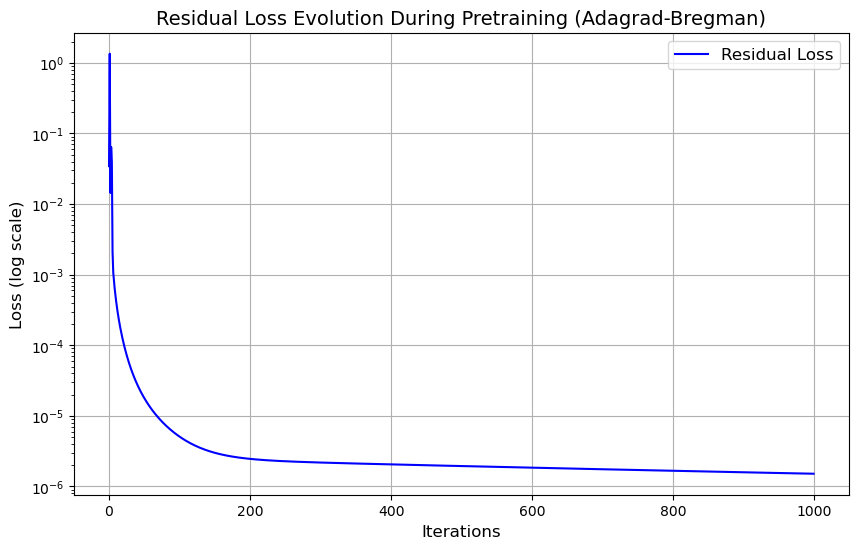

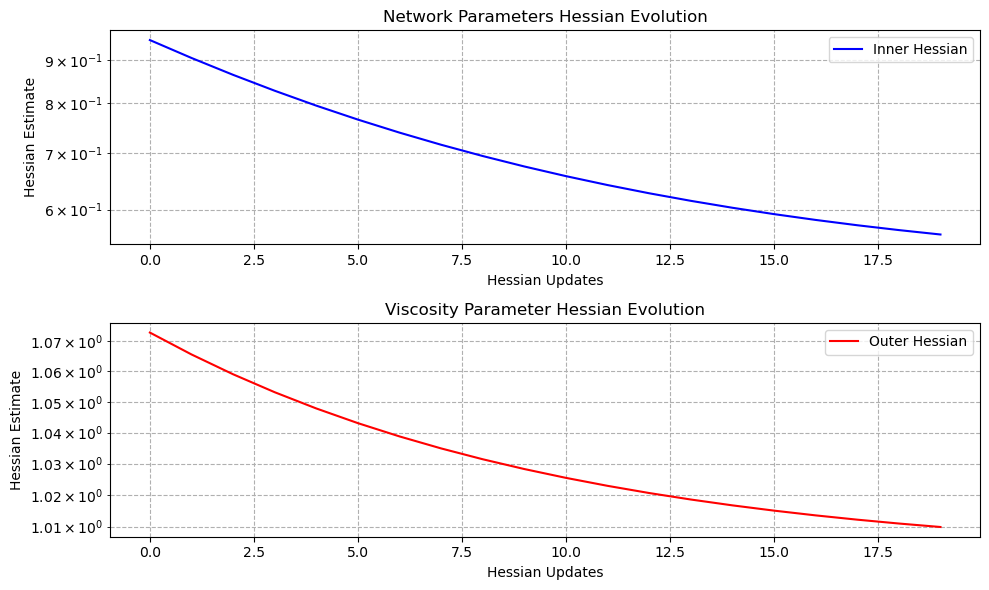

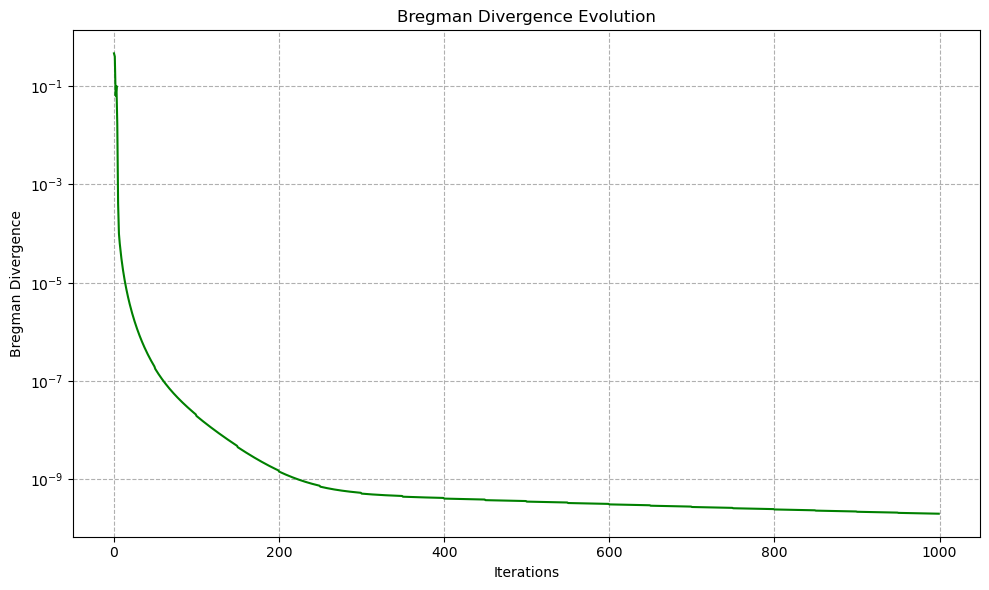


Finetuning with Adagrad-Bregman (using Hessian-based Bregman divergence)...
Starting finetuning with Adagrad-Bregman...
[Hessian Update] Inner H = 5.547e-01, Outer H = 1.009e+00
Initial parameters - Net: -0.07176679690343457, U0: 0.5711716568697517, ν: 0.001
[Hessian Update] Inner H = 5.492e-01, Outer H = 1.008e+00
Net param - Current: -0.07176679690343457, Prev: -0.07176679690343457, Diff: 0.0
U0 param - Current: 0.5711716568697517, Prev: 0.5711716568697517, Diff: 0.0
ν - Current: 0.001, Prev: 0.001, Diff: 0.0
After step - Net Bregman: 1.306e-01, U0 Bregman: 7.124e-02
ν Bregman: 1.956e-04, Total: 2.020e-01
[Finetune] iter 0: Data loss = 3.948e-02, Residual loss = 1.514e-06, Current ν = 0.02070, Bregman div = 2.020e-01
[Bregman] 15/15 param groups have non-zero differences
[Bregman] Bregman sum: 8.847992e-05
[Bregman] 6/6 param groups have non-zero differences
[Bregman] Bregman sum: 5.886699e-05
[Hessian Update] Inner H = 5.443e-01, Outer H = 1.007e+00
Net param - Current: -0.07148218

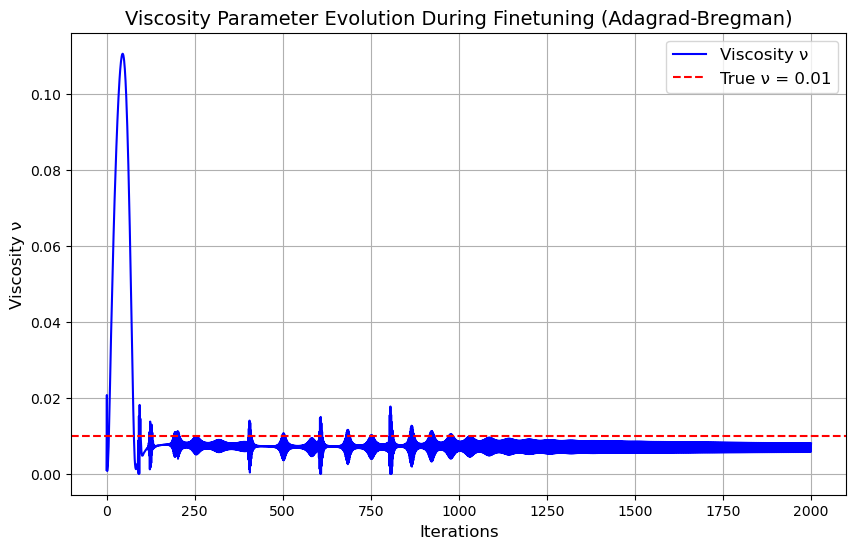

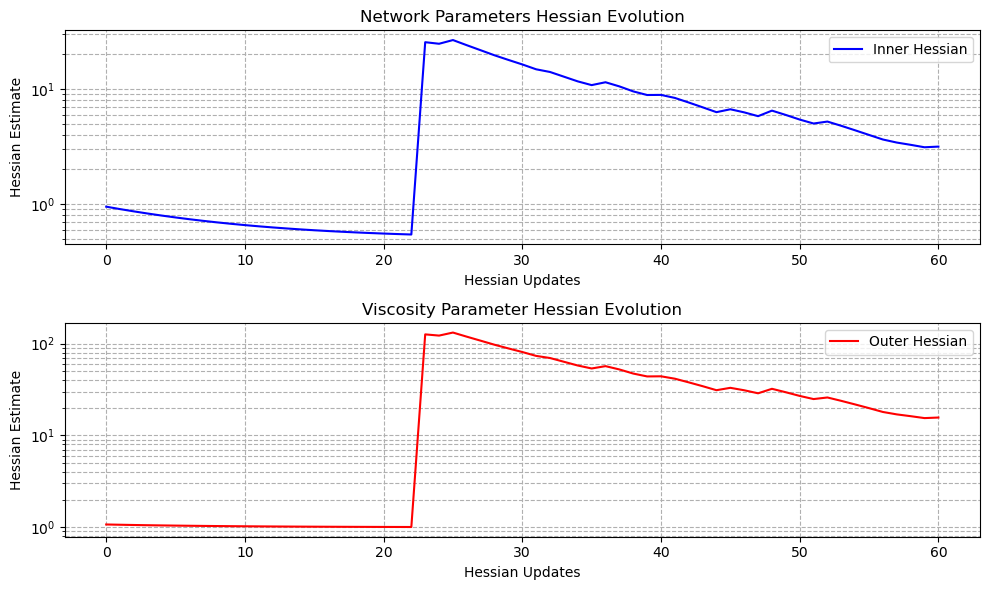

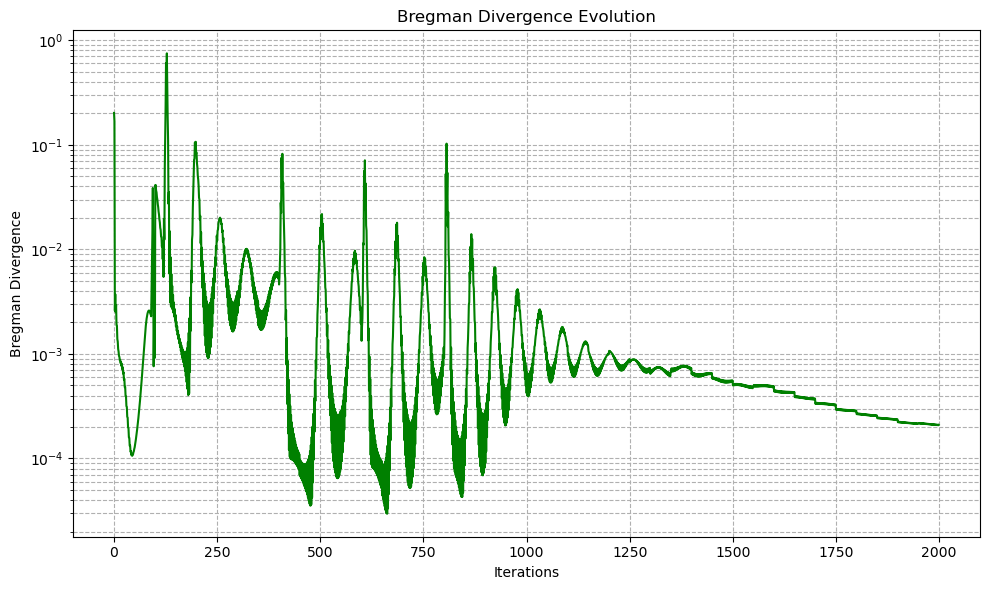

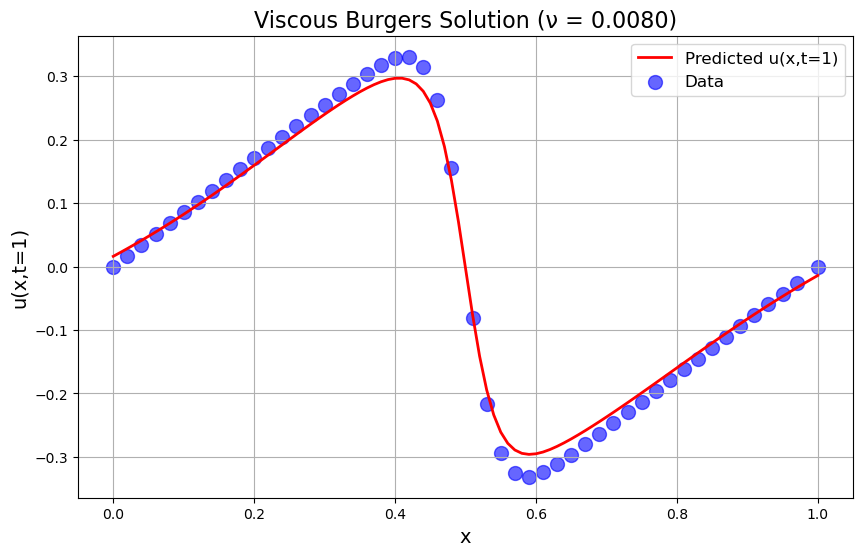

Identified viscosity ν = 0.007989
True viscosity ν = 0.01
Relative error: 20.11%


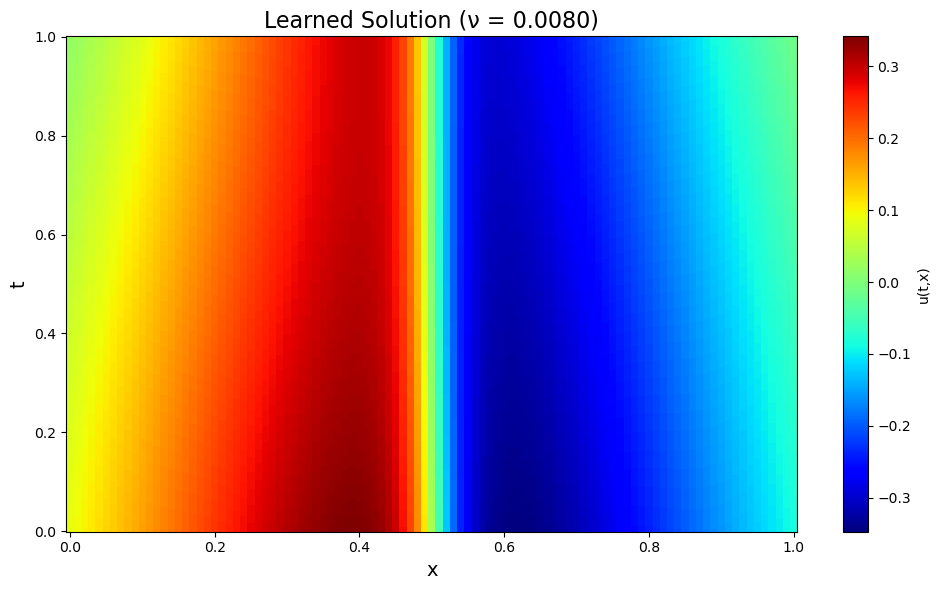

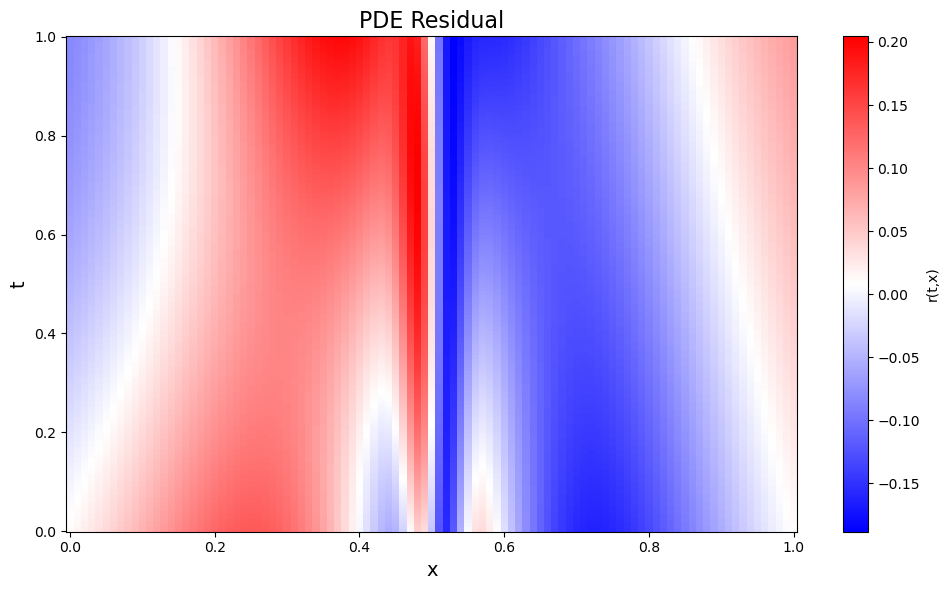

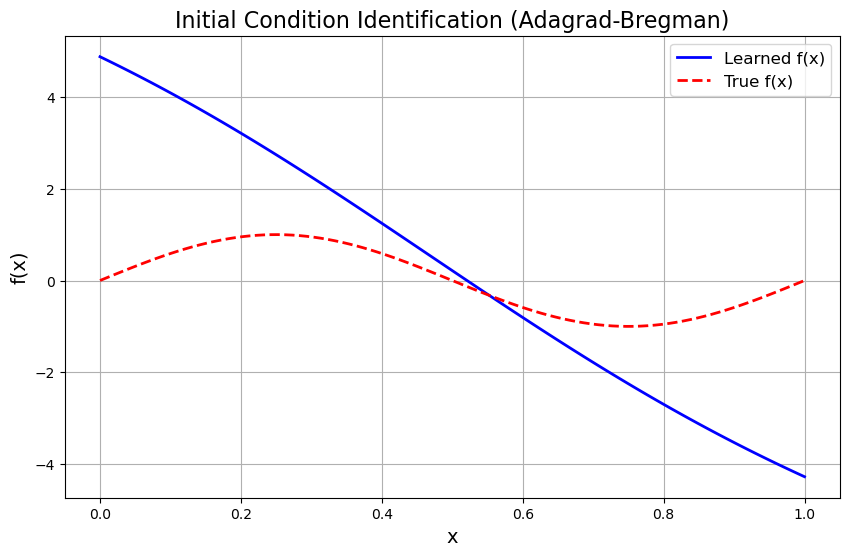

Final Validation Data Loss = 3.594e-04

--- Adagrad with Bregman Divergence Analysis ---
Incorporating Bregman divergence into Adagrad provides:
1. Adaptive learning rates from Adagrad's per-parameter adaptivity
2. Bregman divergence regularization aligned with PDE structure
3. Better optimization trajectory guided by local curvature


In [20]:
##############################################################################
# 8. Main Routine for Adagrad with Bregman Divergence
##############################################################################
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # --- Forward Solve & Dataset Generation ---
    true_initial_condition = lambda x: np.sin(2 * np.pi * x)
    true_viscosity = 0.01  # True viscosity
    print(f"True viscosity ν = {true_viscosity}")
    
    # For data generation, use the true viscosity
    t_arr, x_arr, U_sol = simulate_viscous_burgers(true_initial_condition, nu=true_viscosity, Nx=101, Nt=200)
    dataset_visc = create_burgers_dataset(t_arr, x_arr, U_sol, N_res=1000, N_dat=50)
    
    # --- Define PDE Problem with Unknown Viscosity ν ---
    # Initial guess (use a different value to test identification)
    initial_viscosity_guess = 0.001
    print(f"Initial viscosity guess = {initial_viscosity_guess}")
    burger_problem = BurgerProblem(dataset_visc, a=1.0, init_nu=initial_viscosity_guess)
    
    # --- Setup Initial Condition Network ---
    param_func = ParamFunction(input_dim=1, output_dim=1, fdepth=3, fwidth=32, activation='tanh')
    
    # Initialize to a reasonable but not exact guess
    def initial_guess_ic(x):
        return 0.7 * np.sin(2 * np.pi * x)  # 70% amplitude of true IC
    
    x_fit = np.linspace(0, 1, 50).reshape(-1,1)
    y_fit = initial_guess_ic(x_fit).reshape(-1,1)
    x_fit_torch = torch.tensor(x_fit, dtype=torch.get_default_dtype()).to(device)
    y_fit_torch = torch.tensor(y_fit, dtype=torch.get_default_dtype()).to(device)
    
    # Initialize param_func with Adagrad
    optimizer_init = optim.Adagrad(param_func.parameters(), lr=0.01)
    for _ in range(300):
        optimizer_init.zero_grad()
        pred = param_func(x_fit_torch)
        loss_init = torch.mean((pred - y_fit_torch)**2)
        loss_init.backward()
        optimizer_init.step()
    
    # Attach the function to the problem
    burger_problem.param_function = param_func
    
    # --- Build Main Network (BurgerDenseNet) that Embeds f(x) ---
    net_adagrad = BurgerDenseNet(depth=4, width=64, input_dim=2, output_dim=1,
                             lambda_transform=lambda x, u: u,
                             with_param=True,
                             param_function=param_func).to(device)
    print("BurgerDenseNet architecture ready")
    
    # --- Create and Train with Adagrad + Bregman Divergence ---
    # Create class for bilevel optimization with Adagrad and Bregman
    class AdagradBregmanBurgers:
        def __init__(self, problem, network):
            self.problem = problem
            self.network = network
            self.dataset = problem.dataset
            
            # Parameters for network and initial condition
            self.param_net = list(network.parameters())
            self.param_u0 = list(problem.param_function.parameters())
            
            # Weight for residual gradient regularization
            self.w_rgrad = 1e-3
            
            # History tracking
            self.loss_history = []
            self.nu_history = []
            self.bregman_divergence_history = []
            self.H_inner_history = []
            self.H_outer_history = []
            
            # Initialize Hessian values
            self.H_inner = 1.0
            self.H_outer = 1.0
            
            # For Bregman divergence computation
            self.hessian_weight = 0.5  # Weight for Hessian in the divergence
            
            # Store previous parameters for Bregman divergence
            self.prev_params = None
            
            # Hessian matrices
            self.P_inner = None
        
        def update_hessian_approximation(self):
            """Update Hessian approximation for Bregman divergence"""
            X_res = self.dataset['X_res_train']
            try:
                # Compute Hessian matrix for inner problem parameters
                H_inner, H_outer = compute_hessian_burgers_analytical(
                    self.problem, self.network, X_res)
                
                # Apply smoothing to avoid instability
                alpha = 0.9  # Smoothing factor
                self.H_inner = alpha * self.H_inner + (1 - alpha) * H_inner
                self.H_outer = alpha * self.H_outer + (1 - alpha) * H_outer
                
                # Store history
                self.H_inner_history.append(self.H_inner)
                self.H_outer_history.append(self.H_outer)
                
                print(f"[Hessian Update] Inner H = {self.H_inner:.3e}, Outer H = {self.H_outer:.3e}")
            except Exception as e:
                print(f"[Hessian Update] Warning: Error computing Hessian - {str(e)}")
        
        def compute_bregman_divergence_quadratic(self, current_params, reference_params):
            """
            Compute the Hessian-based Bregman divergence using scalar Hessian:
            D_φ(W,Ŵ) = (1/2)(W-Ŵ)ᵀH(W-Ŵ)
            """
            # Use a floating point tensor with correct dtype
            bregman_sum = torch.tensor(0.0, device=device, dtype=torch.get_default_dtype())
            
            # Debug info
            total_params = len(current_params)
            non_zero_diffs = 0
            
            for i, (curr, ref) in enumerate(zip(current_params, reference_params)):
                # Compute parameter differences: (W-Ŵ)
                param_diff = curr - ref
                
                # Calculate difference magnitude
                diff_magnitude = torch.sum(torch.abs(param_diff)).item()
                
                # Only add to the sum if difference is significant
                if diff_magnitude > 1e-12:
                    non_zero_diffs += 1
                    # Simple quadratic form with scalar H
                    bregman_term = 0.5 * self.H_inner * torch.sum(param_diff**2)
                    bregman_sum += bregman_term
            
            # Debug info (only print occasionally)
            if random.random() < 0.01:  # Print with 1% probability
                print(f"[Bregman] {non_zero_diffs}/{total_params} param groups have non-zero differences")
                if non_zero_diffs > 0:
                    print(f"[Bregman] Bregman sum: {bregman_sum.item():.6e}")
                    
            return bregman_sum
        
        def compute_bregman_gradient(self, current_params, reference_params):
            """
            Compute the gradient of the Bregman divergence:
            ∇_W D_φ(W,Ŵ) = H(W-Ŵ)
            """
            bregman_grads = []
            
            for curr, ref in zip(current_params, reference_params):
                # Compute parameter differences: (W-Ŵ)
                param_diff = curr - ref
                
                # Compute Bregman gradient: H(W-Ŵ)
                bregman_grad = self.H_inner * param_diff
                bregman_grads.append(bregman_grad)
            
            return bregman_grads
        
        def residual_loss(self):
            """Compute PDE residual loss"""
            return self.problem.residual_loss(self.network)
        
        def data_loss(self):
            """Compute data-fitting loss"""
            return self.problem.get_data_loss(self.network)

        def pretrain_adagrad_bregman(self, max_iter=500, lr=0.01, eps=1e-8, bregman_weight=0.2):
            """
            Pretrain the network using Adagrad optimizer with Bregman divergence.
            This implements the approach described in the LaTeX formulation.
            """
            print("Starting pretraining with Adagrad-Bregman...")
            
            # Initialize Hessian approximation
            self.update_hessian_approximation()
            
            # Create PyTorch optimizer for network parameters
            optimizer = optim.Adagrad(self.param_net, lr=lr, eps=eps)
            
            # Store current parameters for Bregman divergence
            with torch.no_grad():
                self.prev_params = [p.clone().detach() for p in self.param_net]
            
            # Add an explicit debug check
            param_before = self.param_net[0][0, 0].item()
            print(f"Initial parameter value: {param_before}")
            
            for it in range(max_iter):
                # Update Hessian approximation periodically
                if it % 50 == 0 and it > 0:
                    self.update_hessian_approximation()
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Compute residual loss
                loss_res = self.residual_loss()
                
                # Backward pass
                loss_res.backward()
                
                # Get current parameters BEFORE optimization step
                current_params = [p.clone() for p in self.param_net]
                
                # Debug prints every 50 iterations
                if it % 50 == 0:
                    param_now = self.param_net[0][0, 0].item()
                    prev_param = self.prev_params[0][0, 0].item()
                    print(f"Iter {it}, Current param: {param_now}, Prev param: {prev_param}")
                    print(f"Diff: {abs(param_now - prev_param)}")
                
                # Step optimizer with standard gradients first
                optimizer.step()
                
                # Now get the updated parameters AFTER the step
                updated_params = [p.clone() for p in self.param_net]
                
                # Compute Bregman divergence for the NEXT iteration
                # Using difference between UPDATED params and PREVIOUS params
                bregman_div = self.compute_bregman_divergence_quadratic(
                    updated_params, self.prev_params)
                self.bregman_divergence_history.append(bregman_div.item())
                
                if it % 50 == 0:
                    updated_param = updated_params[0][0, 0].item()
                    print(f"After step, param: {updated_param}")
                    print(f"Bregman div: {bregman_div.item()}")
                
                # For iteration > 0, apply Bregman correction
                if it > 0:
                    # Compute gradient of Bregman divergence: ∇_W D_φ(W,Ŵ) = H(W-Ŵ)
                    bregman_grads = self.compute_bregman_gradient(
                        current_params, self.prev_params)
                    
                    # Apply Bregman correction as a separate step
                    with torch.no_grad():
                        for i, (param, bgrad) in enumerate(zip(self.param_net, bregman_grads)):
                            # Apply bregman correction: p = p - lr * bregman_weight * bgrad
                            # (This is done separately from the Adagrad step)
                            state = optimizer.state[param]
                            
                            # Get the adaptive learning rate from Adagrad's state
                            if 'sum' in state:
                                # Use the same adaptive rate that Adagrad computed
                                adagrad_lr = lr / (torch.sqrt(state['sum']) + eps)
                                param.data.addcmul_(bgrad, adagrad_lr, value=-bregman_weight)
                            else:
                                # Fallback if no state yet
                                param.data.add_(bgrad, alpha=-lr * bregman_weight)
                
                # Store parameters for next iteration's Bregman divergence
                with torch.no_grad():
                    self.prev_params = [p.clone().detach() for p in self.param_net]
                
                # Track loss and print progress
                self.loss_history.append(loss_res.item())
                
                if it % 50 == 0:
                    bregman_str = ""
                    if len(self.bregman_divergence_history) > 0:
                        bregman_str = f", Bregman div = {self.bregman_divergence_history[-1]:.3e}"
                        
                    print(f"[Pretrain] iter {it}: Residual loss = {loss_res.item():.3e}{bregman_str}")
            
            print("Pretraining completed.")
            
        def finetune_adagrad_bregman(self, max_iter=1000, lr_upper=1e-2, lr_lower=5e-3, 
                         lr_nu=2e-2, eps=1e-8, bregman_weight=0.2):
            """
            Finetune with Adagrad-Bregman for bilevel optimization.
            
            This uses separate optimizers for different parameter groups but applies
            the Bregman divergence regularization to both inner and outer problems.
            """
            print("Starting finetuning with Adagrad-Bregman...")
            
            # Initialize Hessian for outer problem
            self.update_hessian_approximation()
            
            # Create Adagrad optimizers with parameter groups
            optimizer_net = optim.Adagrad(self.param_net, lr=lr_lower, eps=eps)
            optimizer_u0 = optim.Adagrad(self.param_u0, lr=lr_upper, eps=eps)
            optimizer_nu = optim.Adagrad([self.problem.nu], lr=lr_nu, eps=eps)
            
            # Store current parameters for Bregman divergence
            with torch.no_grad():
                self.prev_params = [p.clone().detach() for p in self.param_net]
                self.prev_u0 = [p.clone().detach() for p in self.param_u0]
                self.prev_nu = self.problem.nu.clone().detach()
            
            # Initialize tracking variables
            best_nu = self.problem.nu.detach().clone()
            best_data_loss = float('inf')
            self.nu_history = [self.problem.nu.item()]
            self.bregman_divergence_history = []  # Reset for finetuning
            
            # Debug: Initial parameter checks
            net_param_before = self.param_net[0][0, 0].item() if len(self.param_net) > 0 else 0
            u0_param_before = self.param_u0[0][0, 0].item() if len(self.param_u0) > 0 else 0
            nu_before = self.problem.nu.item()
            print(f"Initial parameters - Net: {net_param_before}, U0: {u0_param_before}, ν: {nu_before}")
            
            for it in range(max_iter):
                # Update Hessian approximation periodically
                if it % 50 == 0:
                    self.update_hessian_approximation()
                
                # Reset all gradients
                optimizer_net.zero_grad()
                optimizer_u0.zero_grad()
                optimizer_nu.zero_grad()
                
                # Compute losses
                d_loss = self.data_loss()
                res_loss = self.residual_loss()
                
                # Combined loss with emphasis on data fitting
                total_loss = 10.0 * d_loss + res_loss
                
                # Backward pass
                total_loss.backward()
                
                # Get current parameters BEFORE optimization step
                current_net_params = [p.clone() for p in self.param_net]
                current_u0_params = [p.clone() for p in self.param_u0]
                current_nu = self.problem.nu.clone()
                
                # Debug: Print parameter differences occasionally
                if it % 50 == 0:
                    if len(self.param_net) > 0:
                        net_param_now = self.param_net[0][0, 0].item()
                        prev_net_param = self.prev_params[0][0, 0].item()
                        print(f"Net param - Current: {net_param_now}, Prev: {prev_net_param}, Diff: {abs(net_param_now - prev_net_param)}")
                    
                    if len(self.param_u0) > 0:
                        u0_param_now = self.param_u0[0][0, 0].item()
                        prev_u0_param = self.prev_u0[0][0, 0].item()
                        print(f"U0 param - Current: {u0_param_now}, Prev: {prev_u0_param}, Diff: {abs(u0_param_now - prev_u0_param)}")
                    
                    nu_now = self.problem.nu.item()
                    prev_nu = self.prev_nu.item()
                    print(f"ν - Current: {nu_now}, Prev: {prev_nu}, Diff: {abs(nu_now - prev_nu)}")
                
                # Standard Adagrad steps
                optimizer_net.step()
                optimizer_u0.step()
                optimizer_nu.step()
                
                # Get updated parameters AFTER the step
                updated_net_params = [p.clone() for p in self.param_net]
                updated_u0_params = [p.clone() for p in self.param_u0]
                updated_nu = self.problem.nu.clone()
                
                # Compute Bregman divergence for each parameter group
                bregman_net_div = self.compute_bregman_divergence_quadratic(
                    updated_net_params, self.prev_params)
                
                bregman_u0_div = self.compute_bregman_divergence_quadratic(
                    updated_u0_params, self.prev_u0)
                
                nu_diff = updated_nu - self.prev_nu
                bregman_nu_div = 0.5 * self.H_outer * (nu_diff**2)
                
                # Total Bregman divergence
                total_bregman = bregman_net_div + bregman_u0_div + bregman_nu_div
                self.bregman_divergence_history.append(total_bregman.item())
                
                # Debug prints
                if it % 50 == 0:
                    print(f"After step - Net Bregman: {bregman_net_div.item():.3e}, U0 Bregman: {bregman_u0_div.item():.3e}")
                    print(f"ν Bregman: {bregman_nu_div.item():.3e}, Total: {total_bregman.item():.3e}")
                
                # For iteration > 0, apply Bregman correction
                if it > 0:
                    # Compute Bregman gradients
                    bregman_net_grads = self.compute_bregman_gradient(
                        current_net_params, self.prev_params)
                    
                    bregman_u0_grads = self.compute_bregman_gradient(
                        current_u0_params, self.prev_u0)
                    
                    bregman_nu_grad = self.H_outer * (current_nu - self.prev_nu)
                    
                    # Apply Bregman correction as separate steps
                    with torch.no_grad():
                        # For network parameters
                        for i, (param, bgrad) in enumerate(zip(self.param_net, bregman_net_grads)):
                            # Apply bregman correction: p = p - lr * bregman_weight * bgrad
                            state = optimizer_net.state[param]
                            if 'sum' in state:
                                # Use adaptive learning rate
                                adagrad_lr = lr_lower / (torch.sqrt(state['sum']) + eps)
                                param.data.addcmul_(bgrad, adagrad_lr, value=-bregman_weight)
                            else:
                                # Fallback
                                param.data.add_(bgrad, alpha=-lr_lower * bregman_weight)
                        
                        # For initial condition parameters
                        for i, (param, bgrad) in enumerate(zip(self.param_u0, bregman_u0_grads)):
                            state = optimizer_u0.state[param]
                            if 'sum' in state:
                                adagrad_lr = lr_upper / (torch.sqrt(state['sum']) + eps)
                                param.data.addcmul_(bgrad, adagrad_lr, value=-bregman_weight)
                            else:
                                param.data.add_(bgrad, alpha=-lr_upper * bregman_weight)
                        
                        # For viscosity parameter
                        state = optimizer_nu.state[self.problem.nu]
                        if 'sum' in state:
                            adagrad_lr = lr_nu / (torch.sqrt(state['sum']) + eps)
                            self.problem.nu.data.add_(bregman_nu_grad, alpha=-bregman_weight * adagrad_lr.item())
                        else:
                            self.problem.nu.data.add_(bregman_nu_grad, alpha=-lr_nu * bregman_weight)
                
                # Ensure viscosity stays positive
                with torch.no_grad():
                    if self.problem.nu.item() <= 0:
                        self.problem.nu.data.fill_(1e-6)
                
                # Store parameters for next iteration's Bregman divergence
                with torch.no_grad():
                    self.prev_params = [p.clone().detach() for p in self.param_net]
                    self.prev_u0 = [p.clone().detach() for p in self.param_u0]
                    self.prev_nu = self.problem.nu.clone().detach()
                
                # Track metrics
                current_nu = self.problem.nu.item()
                self.nu_history.append(current_nu)
                
                # Track best solution
                current_data_loss = d_loss.item()
                if current_data_loss < best_data_loss:
                    best_data_loss = current_data_loss
                    best_nu = self.problem.nu.clone()
                
                # Print progress
                if it % 50 == 0:
                    bregman_str = ""
                    if len(self.bregman_divergence_history) > 0:
                        bregman_str = f", Bregman div = {self.bregman_divergence_history[-1]:.3e}"
                        
                    print(f"[Finetune] iter {it}: Data loss = {d_loss.item():.3e}, "
                        f"Residual loss = {res_loss.item():.3e}, "
                        f"Current ν = {current_nu:.5f}{bregman_str}")
                    
                    # Check if parameters are actually changing between iterations
                    if it > 0 and it % 200 == 0:
                        if len(updated_net_params) > 0 and len(self.param_net) > 0:
                            after_step = self.param_net[0][0, 0].item()
                            print(f"Parameter after Bregman step: {after_step}")
                            net_change = abs(after_step - net_param_now)
                            print(f"Net param change: {net_change:.3e}")
                        
                        if abs(current_nu - self.prev_nu.item()) < 1e-8:
                            print("Warning: ν is barely changing. Increasing learning rate.")
                            for param_group in optimizer_nu.param_groups:
                                param_group['lr'] = min(param_group['lr'] * 1.5, 0.1)
            
            # Use best nu found
            self.problem.nu.data = best_nu
            print(f"Final best viscosity: {best_nu.item():.5f}")
                
        def visualize_hessian_history(self):
            """Plot the Hessian estimates over time"""
            plt.figure(figsize=(10, 6))
            
            plt.subplot(2, 1, 1)
            plt.semilogy(self.H_inner_history, 'b-', label='Inner Hessian')
            plt.grid(True, which="both", ls="--")
            plt.xlabel('Hessian Updates')
            plt.ylabel('Hessian Estimate')
            plt.title('Network Parameters Hessian Evolution')
            plt.legend()
            
            if len(self.H_outer_history) > 0:
                plt.subplot(2, 1, 2)
                plt.semilogy(self.H_outer_history, 'r-', label='Outer Hessian')
                plt.grid(True, which="both", ls="--")
                plt.xlabel('Hessian Updates')
                plt.ylabel('Hessian Estimate')
                plt.title('Viscosity Parameter Hessian Evolution')
                plt.legend()
            
            plt.tight_layout()
            plt.show()
        
        def visualize_bregman_divergence(self):
            """Plot the Bregman divergence over iterations"""
            if len(self.bregman_divergence_history) > 0:
                plt.figure(figsize=(10, 6))
                plt.semilogy(self.bregman_divergence_history, 'g-')
                plt.grid(True, which="both", ls="--")
                plt.xlabel('Iterations')
                plt.ylabel('Bregman Divergence')
                plt.title('Bregman Divergence Evolution')
                plt.tight_layout()
                plt.show()
    
    # Create the trainer
    adagrad_bilo = AdagradBregmanBurgers(burger_problem, net_adagrad)
    
    # Pretrain with Adagrad-Bregman
    print("\nPretraining with Adagrad-Bregman (using Hessian-based Bregman divergence)...")
    adagrad_bilo.pretrain_adagrad_bregman(
        max_iter=1000, 
        lr=0.01,           # Base learning rate
        eps=1e-8,          # For numerical stability
        bregman_weight=0.2 # Weight for Bregman gradient term
    )
    
    # Plot pretraining loss history
    plt.figure(figsize=(10, 6))
    plt.semilogy(adagrad_bilo.loss_history, 'b-', label='Residual Loss')
    plt.grid(True)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Loss (log scale)', fontsize=12)
    plt.title('Residual Loss Evolution During Pretraining (Adagrad-Bregman)', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()
    
    # Plot Hessian history and Bregman divergence
    adagrad_bilo.visualize_hessian_history()
    adagrad_bilo.visualize_bregman_divergence()
    
    # Finetune with Adagrad-Bregman
    print("\nFinetuning with Adagrad-Bregman (using Hessian-based Bregman divergence)...")
    adagrad_bilo.finetune_adagrad_bregman(
        max_iter=2000, 
        lr_upper=0.01,     # For initial condition
        lr_lower=0.005,    # For network
        lr_nu=0.02,        # For viscosity
        eps=1e-8,          # For numerical stability
        bregman_weight=0.2 # Weight for Bregman gradient term
    )
    
    # Plot viscosity evolution
    plt.figure(figsize=(10, 6))
    plt.plot(adagrad_bilo.nu_history, 'b-', label='Viscosity ν')
    plt.axhline(y=true_viscosity, color='r', linestyle='--', label=f'True ν = {true_viscosity}')
    plt.grid(True)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Viscosity ν', fontsize=12)
    plt.title('Viscosity Parameter Evolution During Finetuning (Adagrad-Bregman)', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()
    
    # Plot Hessian history and Bregman divergence for finetuning
    adagrad_bilo.visualize_hessian_history()
    adagrad_bilo.visualize_bregman_divergence()
    
    # --- Visualization and Reporting Results ---
    burger_problem.plot_results(net_adagrad)
    
    # Compare identified vs true viscosity
    identified_viscosity = burger_problem.nu.item()
    print(f"Identified viscosity ν = {identified_viscosity:.6f}")
    print(f"True viscosity ν = {true_viscosity}")
    print(f"Relative error: {abs(identified_viscosity - true_viscosity)/true_viscosity*100:.2f}%")
    
    # Visualize solution and residual
    visualize_solution_2d(net_adagrad, dataset_visc['t_arr'], dataset_visc['x_arr'], 
                         title=f"Learned Solution (ν = {identified_viscosity:.4f})")
    visualize_residual_2d(burger_problem, net_adagrad, dataset_visc['t_arr'], dataset_visc['x_arr'], 
                         title="PDE Residual")
    
    # Plot learned initial condition
    plt.figure(figsize=(10, 6))
    x_plot = torch.linspace(0, 1, 100, dtype=torch.get_default_dtype()).reshape(-1,1).to(device)
    with torch.no_grad():
        u0_pred = burger_problem.param_function(x_plot).cpu().numpy()
    
    plt.plot(x_plot.cpu().numpy(), u0_pred, 'b-', linewidth=2, label="Learned f(x)")
    plt.plot(x_plot.cpu().numpy(), np.sin(2*np.pi*x_plot.cpu().numpy()), 'r--', linewidth=2, label="True f(x)")
    plt.grid(True)
    plt.xlabel("x", fontsize=14)
    plt.ylabel("f(x)", fontsize=14)
    plt.title("Initial Condition Identification (Adagrad-Bregman)", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()
    
    # Final validation
    val_loss = burger_problem.validate(net_adagrad)
    print(f"Final Validation Data Loss = {val_loss:.3e}")
    
    # --- Analysis of Adagrad-Bregman Properties ---
    print("\n--- Adagrad with Bregman Divergence Analysis ---")
    print("Incorporating Bregman divergence into Adagrad provides:")
    print("1. Adaptive learning rates from Adagrad's per-parameter adaptivity")
    print("2. Bregman divergence regularization aligned with PDE structure")
    print("3. Better optimization trajectory guided by local curvature")